# Process ML Model

### Load Training and Testing datasets

In [1]:
import numpy as np
import pandas as pd

#Load all training data
X_train = pd.read_csv('Inputs\\train_test_sets\\training.csv')
y_train = X_train.pop('Label')
print(X_train.shape)

#Load all testing data
X_test = pd.read_csv('Inputs\\train_test_sets\\testing.csv')
y_test = X_test.pop('Label')
print(X_test.shape)

(999856, 71)
(1499016, 71)


In [2]:
print('Shape of Training Set:', X_train.shape)
print('Shape of Testing Set:', X_test.shape)
dist = pd.DataFrame()
dist['y_train Freq'] = y_train.value_counts()
dist['y_train %'] = y_train.value_counts(normalize=True)
dist['y_test Freq'] = y_test.value_counts()
dist['y_test %'] = y_test.value_counts(normalize=True)
dist.style.format("{:.3%}", subset=['y_train %', 'y_test %'])

Shape of Training Set: (999856, 71)
Shape of Testing Set: (1499016, 71)


,y_train Freq,y_train %,y_test Freq,y_test %
Label,,,,
DoS attacks-Hulk,164962,16.499%,115478,7.704%
DDOS attack-HOIC,156456,15.648%,171503,11.441%
DDoS attacks-LOIC-HTTP,151250,15.127%,144048,9.610%
Bot,129813,12.983%,71548,4.773%
Benign,121965,12.198%,847255,56.521%
Infilteration,120476,12.049%,40160,2.679%
SSH-Bruteforce,84521,8.453%,46897,3.129%
DoS attacks-GoldenEye,31131,3.114%,10377,0.692%
FTP-BruteForce,29045,2.905%,48339,3.225%


### Commence Training

#### Undersampling and Oversampling to account for the imbalanced Training Set

In [5]:
from collections import Counter
Counter(y_train)

Counter({'DoS attacks-Hulk': 164962,
         'DDOS attack-HOIC': 156456,
         'DDoS attacks-LOIC-HTTP': 151250,
         'Bot': 129813,
         'Benign': 121965,
         'Infilteration': 120476,
         'SSH-Bruteforce': 84521,
         'DoS attacks-GoldenEye': 31131,
         'FTP-BruteForce': 29045,
         'DoS attacks-Slowloris': 8243,
         'DDOS attack-LOIC-UDP': 1298,
         'Brute Force -Web': 458,
         'Brute Force -XSS': 173,
         'SQL Injection': 65})

In [6]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

#Define the over sampling and under sampling dictionaries
dictUnderSample = { 'DoS attacks-Hulk': 60000,
                    'DDOS attack-HOIC': 60000,
                    'DDoS attacks-LOIC-HTTP': 60000,
                    'Bot': 60000,
                    'Benign': 60000,
                    'Infilteration': 60000,
                    'SSH-Bruteforce': 60000,
                    'DoS attacks-GoldenEye': 31131,
                    'FTP-BruteForce': 29045,
                    'DoS attacks-Slowloris': 8243,
                    'DDOS attack-LOIC-UDP': 1298,
                    'Brute Force -Web': 458,
                    'Brute Force -XSS': 173,
                    'SQL Injection': 65}

dictOverSample = {  'DoS attacks-Hulk': 60000,
                    'DDOS attack-HOIC': 60000,
                    'DDoS attacks-LOIC-HTTP': 60000,
                    'Bot': 60000,
                    'Benign': 60000,
                    'Infilteration': 60000,
                    'SSH-Bruteforce': 60000,
                    'DoS attacks-GoldenEye': 60000,
                    'FTP-BruteForce': 60000,
                    'DoS attacks-Slowloris': 60000,
                    'DDOS attack-LOIC-UDP': 60000,
                    'Brute Force -Web': 60000,
                    'Brute Force -XSS': 60000,
                    'SQL Injection': 60000}

#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
print(len(X_train2))
y_train2.value_counts()

809045


Label
Benign                    60000
Bot                       60000
Brute Force -Web          60000
Brute Force -XSS          60000
DDOS attack-HOIC          60000
DDOS attack-LOIC-UDP      60000
DDoS attacks-LOIC-HTTP    60000
DoS attacks-GoldenEye     60000
DoS attacks-Hulk          60000
DoS attacks-Slowloris     60000
Infilteration             60000
SQL Injection             60000
SSH-Bruteforce            60000
FTP-BruteForce            29045
Name: count, dtype: int64

#### Train the model

In [10]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import fbeta_score, matthews_corrcoef
from CustomFunctions import Timer


# Create a pipeline with ColumnTransformer to drop columns
features_to_drop = ['Protocol', 'Dst Port Class']

#Define the main workflow pipeline
workflowPipe = Pipeline(steps=[
                            ('preprocessing', ColumnTransformer(transformers=[('column dropper', 'drop', features_to_drop)], remainder='passthrough')),
                            ('classifier', LGBMClassifier(boosting_type='dart', objective='multiclass', n_jobs=-1, verbose=-1, 
                                                         n_estimators=150, learning_rate=0.066, max_depth=11, max_bin=400 ))
                        ])

#Run the pipeline
t = Timer()
t.start()
workflowPipe.fit(X_train2, y_train2)
t.stop(timerName='Training of model')

Training of model took 80.11 seconds (902.52 CPU seconds)


#### Assess model performance

In [12]:
from CustomFunctions import Timer

#Measure the execution performance
t = Timer()
t.start()
pred_test_1000 = workflowPipe.predict(X_test.head(1000))
t.stop('Executing model over the first 1000 rows of Testing Set')

#Obtain predictions on the full Training dataset
pred_train = workflowPipe.predict(X_train)

#Obtain predictions on the full Testing dataset
t.start()
pred_test = workflowPipe.predict(X_test)
t.stop('Executing model over the entire Testing set (' + str(len(X_test)) + ') rows')


Executing model over the first 1000 rows of Testing Set took 0.02 seconds (0.16 CPU seconds)
Executing model over the entire Testing set (1499016) rows took 15.39 seconds (161.08 CPU seconds)



Training Set: Size:  (999856, 71)
Training Set: F2 score:  0.9664790370784988
Training Set: Matthews Correlation Coefficient:  0.9731259085803664

Testing Set: Size:  (1499016, 71)
Testing Set: F2 score:  0.8563923970450534
Testing Set: Matthews Correlation Coefficient:  0.9002581940472755


                        precision  recall  f2-score  support
Benign                       1.00    0.87      0.90  847,255
Bot                          1.00    1.00      1.00   71,548
Brute Force -Web             0.24    0.94      0.60      153
Brute Force -XSS             0.25    0.95      0.61       57
DDOS attack-HOIC             1.00    1.00      1.00  171,503
DDOS attack-LOIC-UDP         0.70    0.99      0.92      432
DDoS attacks-LOIC-HTTP       1.00    1.00      1.00  144,048
DoS attacks-GoldenEye        1.00    1.00      1.00   10,377
DoS attacks-Hulk             1.00    1.00      1.00  115,478
DoS attacks-Slowloris        0.98    1.00      1.00    2,747
FTP-BruteForce               1.00  

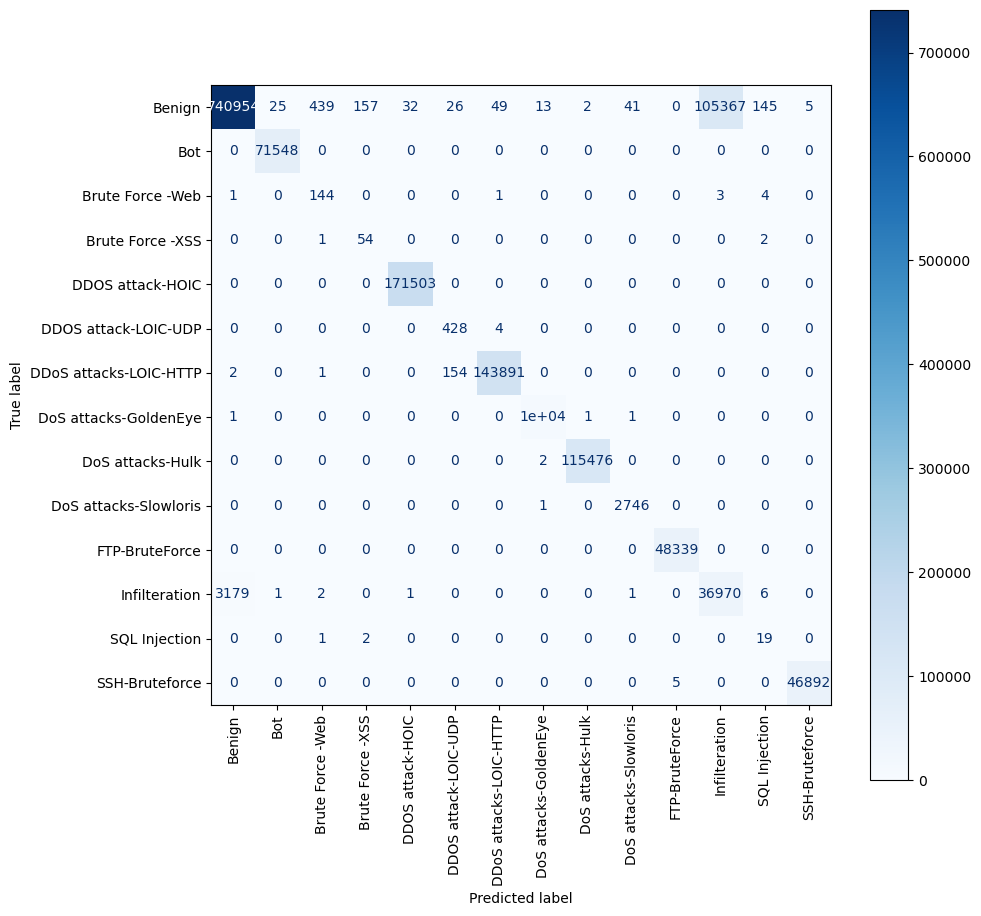

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from CustomFunctions import classification_report_IDS

#Output results
print('\nTraining Set: Size: ', X_train.shape)
print('Training Set: F2 score: ', fbeta_score(y_train, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')

#Plot the confusion matrix
c = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_test), display_labels=workflowPipe.classes_)
fig, ax = plt.subplots(figsize=(10,10))
c.plot(ax = ax, cmap='Blues', xticks_rotation='vertical')

## Classification Report
classification_report_IDS(y_test, pred_test)